In [108]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

# This detect if cuda is available for GPU training otherwise it will use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

print(imsize)


128


In [109]:
loader = transforms.Compose([
    transforms.Resize(imsize),  # Resize the smaller edge to imsize, keeping aspect ratio
    transforms.CenterCrop(imsize),  # Crop the center to make it square
    transforms.ToTensor()])  # Convert to tensor

# Helper function (unchanged)
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


In [111]:

style_img = image_loader("/content/starry-night-1093721 (1).jpg")
content_img = image_loader("/content/Mansions (1).jpeg")

assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"


<Figure size 640x480 with 0 Axes>

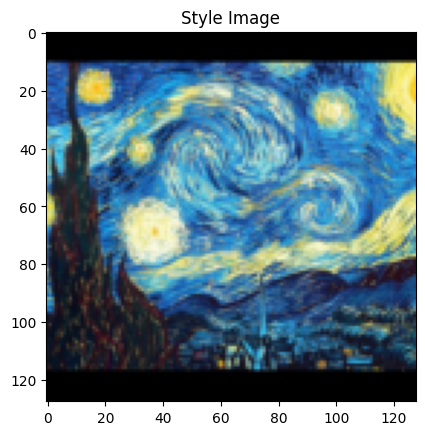

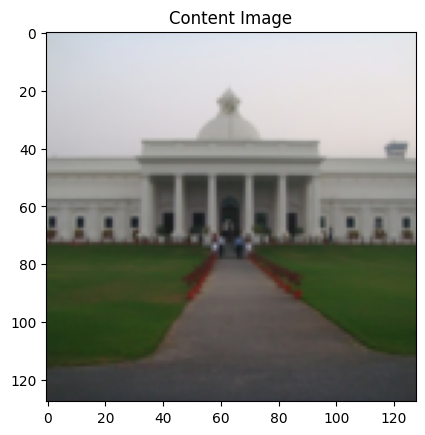

In [112]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

# Helper function to show the tensor as a PIL image
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')


In [118]:
# Custom content loss
class ContentLoss(nn.Module):
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


In [119]:
# This is for the style loss
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature map.
    return G.div(a * b * c * d)

# Same structure as the content loss
class StyleLoss(nn.Module):
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [120]:
# Importing the VGG 19 model like in the paper (here we set it to evaluation mode)
cnn = models.vgg19(pretrained=True).features.to(device).eval()

# VGG network is normalized with special values for the mean and std
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std


In [121]:
# Here we insert the loss layer at the right spot

# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to our list of content/style losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


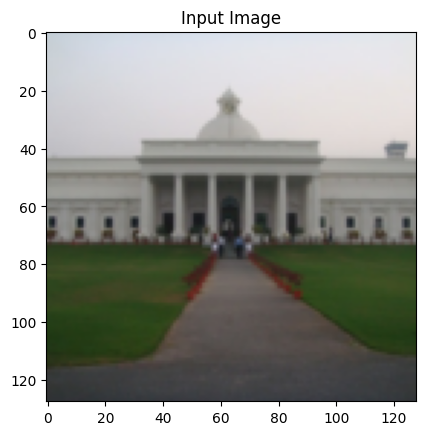

In [117]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')


In [122]:
# This type of optimizer was preferred by the author of the paper
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer


In [123]:
# This will run the neural style transfer
# It will create image that goes above 1 or below 0, however it will be normalized
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=400,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 100 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction to have the tensors between 0 and 1
    input_img.data.clamp_(0, 1)

    return input_img


In [125]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img, num_steps=6000)

plt.figure()


# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()


Building the style transfer model..


<ipython-input-120-8e4c6952a1dd>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
<ipython-input-120-8e4c6952a1dd>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [100]:
Style Loss : 161.070923 Content Loss: 47.940899

run [200]:
Style Loss : 70.353844 Content Loss: 46.269890

run [300]:
Style Loss : 44.187035 Content Loss: 44.034416

run [400]:
Style Loss : 29.389174 Content Loss: 42.100605

run [500]:
Style Loss : 32.199696 Content Loss: 40.904686

run [600]:
Style Loss : 20.704424 Content Loss: 39.977783

run [700]:
Style Loss : 23.833828 Content Loss: 39.600277

run [800]:
Style Loss : 600.166443 Content Loss: 38.209621

run [900]:
Style Loss : 42.071404 Content Loss: 38.795563

run [1000]:
Style Loss : 26.570946 Content Loss: 39.091801

run [1100]:
Style Loss : 436.899994 Content Loss: 38.991039

run [1200]:
Style Loss : 9726.265625 Content Loss: 43.269844

run [1300]:
Style Loss : 166.061066 Content Loss: 47.649258

run [1400]:
Style Loss : 81.462654 Content Loss: 45.980175

run [1500]:
Style Loss : 49.974697 Content Loss: 44.228317

run [1600]:
Style Loss : 29.120918 Content Loss: 42.495419

run [1700]:
Style Loss : 20.30

<Figure size 640x480 with 0 Axes>

In [126]:
plt.savefig('output_image.png', bbox_inches='tight')

<ipython-input-9-b7e7eb78c15a>:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(size.astype(int), Image.ANTIALIAS)


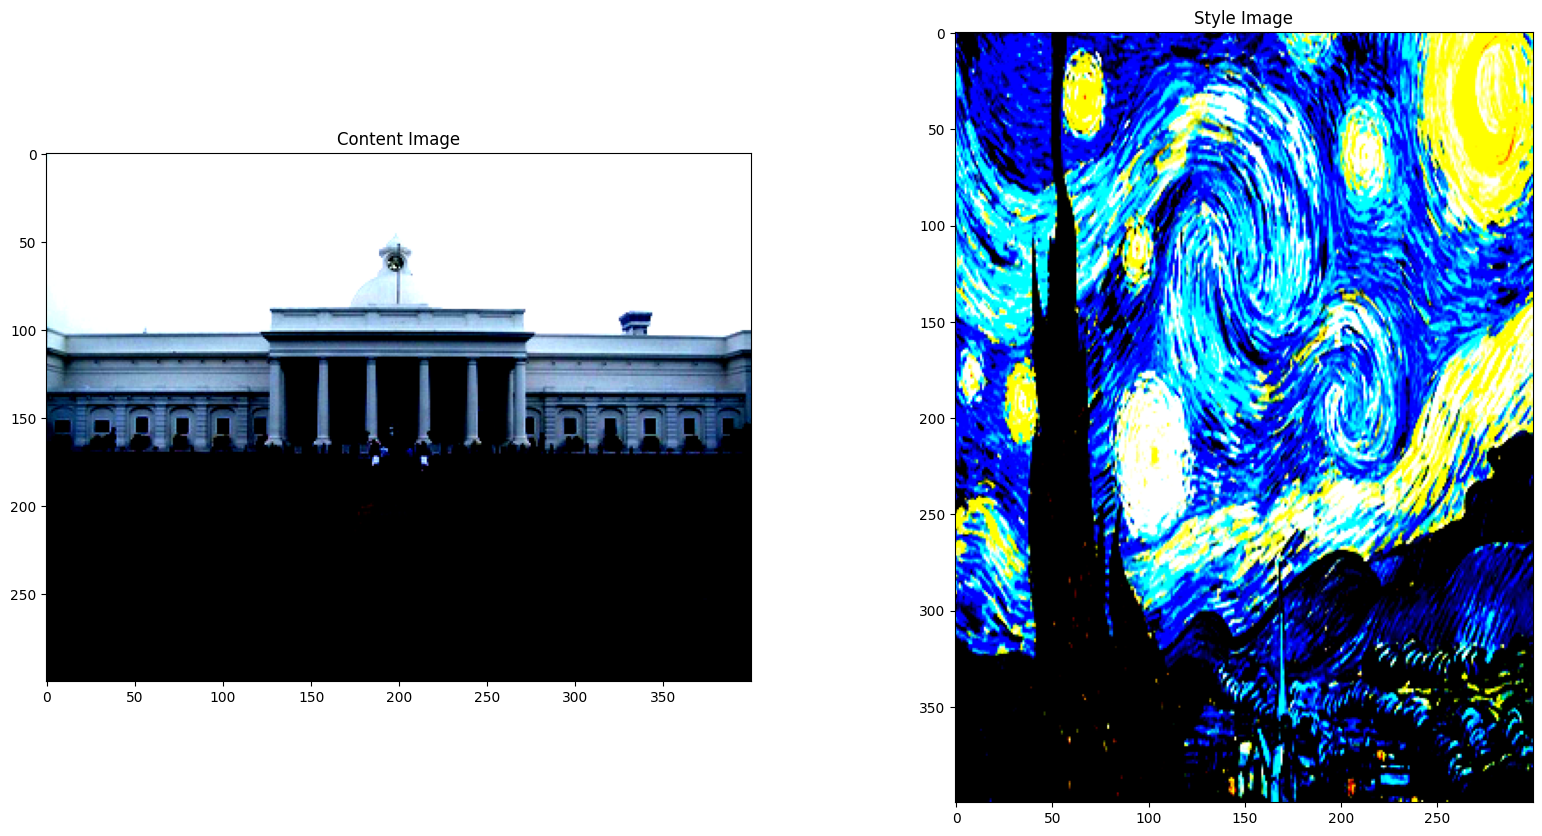

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:08<00:00, 71.4MB/s]


Step 400, Total loss 169098544.0


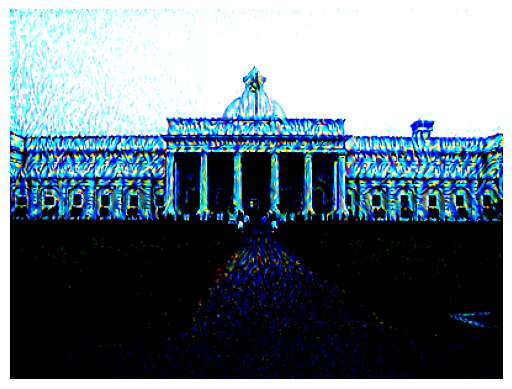

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Function to load and preprocess images
def load_image(image_path, transform=None, max_size=400, shape=None):
    image = Image.open(image_path).convert('RGB')
    if max_size:
        scale = max_size / max(image.size)
        size = np.array(image.size) * scale
        image = image.resize(size.astype(int), Image.ANTIALIAS)

    if shape:
        image = image.resize(shape, Image.LANCZOS)

    if transform:
        image = transform(image).unsqueeze(0)
    return image

# Function to convert tensor to image
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image.clip(0, 1)
    return image

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Load images
content_image = load_image('/content/Mansions (1).jpeg', transform)
style_image = load_image('/content/starry-night-1093721.jpg', transform, shape=[content_image.size(2), content_image.size(3)])

# Display images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content_image))
ax1.set_title('Content Image')
ax2.imshow(im_convert(style_image))
ax2.set_title('Style Image')
plt.show()

# Load the VGG19 model
vgg = models.vgg19(pretrained=True).features

# Freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)
content_image = content_image.to(device)
style_image = style_image.to(device)

# Helper function to get the features of an image
def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # Content layer
            '28': 'conv5_1'
        }
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features

# Get features
content_features = get_features(content_image, vgg)
style_features = get_features(style_image, vgg)

# Function to calculate the Gram Matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Get the Gram Matrices of style features
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a target image and clone content_image
target = content_image.clone().requires_grad_(True).to(device)

# Define style and content weights
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e6  # beta

# Set optimizer
optimizer = optim.Adam([target], lr=0.003)

# Training loop
steps = 2000  # number of iterations
for step in range(1, steps+1):
    target_features = get_features(target, vgg)

    # Calculate content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # Calculate style loss
    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        style_loss += layer_style_loss / (d * h * w)

    # Total loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # Update target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Display intermediate result
    if step % 400 == 0:
        print(f"Step {step}, Total loss {total_loss.item()}")
        plt.imshow(im_convert(target))
        plt.axis('off')
        plt.show()

# Save the final output
save_image(target, 'output_image.jpg')
